# Preparation

## Importing necessary libraries and dataset

In [1]:
import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

from base_functions import *
test_script()

Script containing strategy evaluation functions were imported successfully!


In [2]:
# Imports df
try:
    df = pd.read_csv('odds_df.csv')
except:
    csv_url = "https://www.football-data.co.uk/new/BRA.csv"
    df = pd.read_csv(csv_url)

# Checking all necessary entries exist and removes unecessary columns
columns_to_keep = ['Season', 'Home', 'Away', 'Res', 'AvgCH', 'AvgCD', 'AvgCA','MaxCH', 'MaxCD', 'MaxCA', 'PSCH', 'PSCD', 'PSCA']
df = df[columns_to_keep]
df = df.dropna(subset=columns_to_keep)

# Isolates the period under analysis
df = df[(df['Season'] >= 2019) & (df['Season'] <= 2024)]
df

,Season,Home,Away,Res,AvgCH,AvgCD,AvgCA,MaxCH,MaxCD,MaxCA,PSCH,PSCD,PSCA
2660,2019,Sao Paulo,Botafogo RJ,H,1.74,3.37,5.14,1.81,3.60,5.80,1.78,3.39,5.61
2661,2019,Atletico-MG,Avai,H,1.53,3.90,6.34,1.58,4.09,7.00,1.56,4.09,6.46
2662,2019,Chapecoense-SC,Internacional,H,2.94,2.94,2.59,3.15,3.20,2.71,3.02,3.03,2.71
2663,2019,Flamengo RJ,Cruzeiro,H,2.21,3.12,3.40,2.32,3.40,3.57,2.32,3.20,3.47
2664,2019,Gremio,Santos,A,1.71,3.41,5.31,1.83,3.60,5.94,1.71,3.58,5.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,2024,Flamengo RJ,Vitoria,D,1.37,5.02,7.66,1.40,5.30,8.25,1.38,5.20,7.93
4936,2024,Fortaleza,Internacional,H,2.59,3.18,2.80,2.65,3.25,2.90,2.62,3.24,2.88
4937,2024,Gremio,Corinthians,A,2.67,3.34,2.61,2.77,3.46,2.74,2.74,3.35,2.66
4938,2024,Juventude,Cruzeiro,A,2.13,3.37,3.44,2.21,3.47,3.59,2.13,3.42,3.59


# Placing random bets
The most basic strategy one could use to place bets is doing so randomly. Of course, very few people would actually do so in reality, but simulating this brings meaningful insights to amateur bettors. Our assumptions for this case are the following:
1. Bettor places a bet a few days before the match, getting odds better than at closing time. We simulate that by using the maximum odds at closing.
2. Bookmaker's vig is evenly spread across outcomes, allowing us to calculate the odds implied probabilities through the multiplication method
3. The true sharpness of the strategy does not change over time. Therefore, we use a complete pooling approach when estimating the strategy's sharpness through MCMC

In [3]:
def place_random_bets(df, seasons):
  """
    Simulates the process of betting randomly across many seasons

    Parameters:
        df (DataFrame): A Pandas DataFrame containing match data. It is expected to have columns
        seasons (list): A list of unique season identifiers (e.g., years or labels) to iterate over.

  """

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Filter the DataFrame for the current season
    season_df = df[df['Season'] == season]

    # Iterate through each match in the season
    for index, row in season_df.iterrows():

      target = random.choice(['H', 'D', 'A']) # Picks a random outcome
      result = row['Res']
      successful_bet = 1 if target == result else 0
      odds_locked = row[f'MaxC{target}']
      profit_loss = (odds_locked - 1) if successful_bet else -1
      pinnacle_odds_implied_probability = (1/row[f'PSC{target}']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )


      # Populates betting log with info specific to each match
      betting_log.loc[len(betting_log)] = {'Season': season,
                                           'Target': target,
                                           'Result': result,
                                           'Successful bet': successful_bet,
                                           'Profit/Loss': profit_loss,
                                           'Odds locked': odds_locked,
                                           'Pinnacle OIP': pinnacle_odds_implied_probability}

  # Summarizes results and returns samples from sharpness posterior
  posterior_samples = summarize_results(seasons, betting_log, "Random Bets")
  return posterior_samples

Below, we have the results of how the strategy performs. As one would expect, the sharpness mean of placing random bets is close to 33%, which makes sense: given we have three possible outcomes, by selecting one at random, we should get around one third of our guesses correctly. What is interestimg to notice is how profits behave. Most people would expect that, by placing random bets, a person would always suffer heavy losses, but that is not always the case. In fact, during our backtests, there were cases when the profits were as high as 17%, and the losses were as low as -29%. Which such a wide range of outcomes, Monte Carlo simulations are crucial in helping us understand what can be expected from the strategy. 

After ten thousand simulations of placing random bets in every match during six seasons, the average profit was 0.28%, meaning that, in expectation, a random bettor would break even. In fact, random bets led to long-term losses (that is, a cumulative loss after the six seasons) in 46.90% of the simulations, meaning that one could perfectly well end up with positive results purely by chance. 

This should be enough to make anyone skeptical of the results of betting influencers. Seeing a small sample of positive results, like the ones that influencers tend to post online, is not an indicative of actual sharpness. If the person behind our backtested performance were an influencer, it is likely they would brag about the 17% profit at the end of the first season. Seeing those results, viewers would probably not expect the -29% losses that were about to come. Yet, it is the same strategy, and the people following the influencers would nearly be putting their money on a coin flip without even knowing. 

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      380      │        122        │ [0.274, 0.366] │       0.32       │  0.31  │    -14.01    │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      380      │        121        │ [0.275, 0.366] │       0.32       │  0.3   │    -1.09     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      380      │        135        │ [0.307, 0.402] │       0.36       │  0.3   │    10.22     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

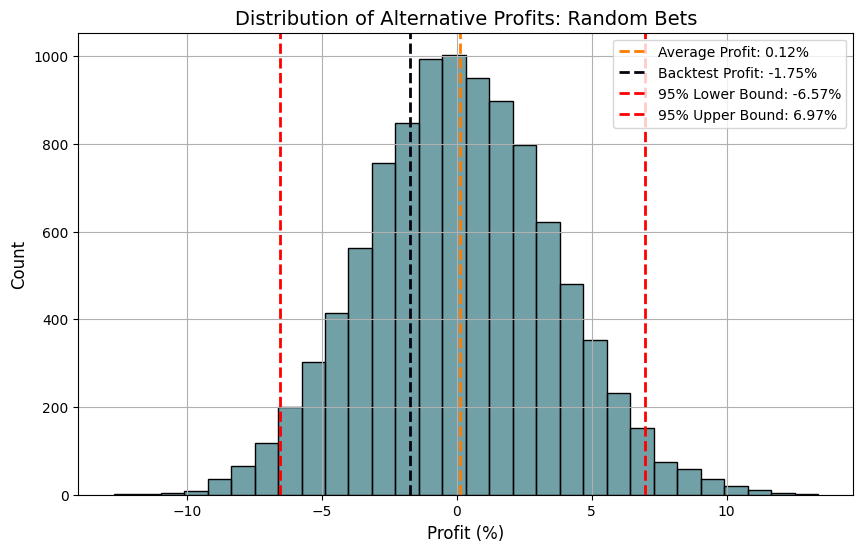


Summary of random effect analysis
  Average profit over simulations: 0.12%
  95% interval of profit: [-6.57%, 6.97%]
  Probability of ending better off than in the backtest: 70.31%
  Probability of ending with a loss: 49.05%


In [5]:
seasons = [i for i in range(2019, 2025)]
posterior_placing_random_bets = place_random_bets(df, seasons)

# Always betting on the home team
A second, more likely strategy a bettor could use is always betting on the home team. This strategy takes advantage of the fact that home teams have some advantage against their opponents, a well-known phenomenon among soccer fans. 

Assumptions:
1. Bettor places a bet a few days before the match, getting odds better than at closing time. We simulate that by using the maximum odds at closing.
2. Bookmaker's vig is evenly spread across outcomes, allowing us to calculate the odds implied probabilities through the multiplication method
3. The true sharpness of the strategy does not change over time. Therefore, we use a complete pooling approach when estimating the strategy's sharpness through MCMC

In [6]:
def always_bet_home(df, seasons):
  """
    Simulates always betting on the home team across multiple seasons.

    Parameters:
        df (DataFrame): A Pandas DataFrame containing match data. It is expected to have columns
        seasons (list): A list of unique season identifiers (e.g., years or labels) to iterate over.

  """

  # Initializes lists to store results for each season
  betting_log = pd.DataFrame(columns=['Season', 'Target', 'Result', 'Successful bet', 'Profit/Loss', 'Odds locked', 'Pinnacle OIP'])

  for season in seasons:
    # Filter the DataFrame for the current season
    season_df = df[df['Season'] == season]

    # Iterate through each match in the season
    for index, row in season_df.iterrows():

      target = 'H'
      result = row['Res']
      successful_bet = 1 if target == result else 0
      odds_locked = row['MaxCH']
      profit_loss = (odds_locked - 1) if successful_bet else -1
      pinnacle_odds_implied_probability = (1/row['PSCH']) / ( (1/row['PSCH']) + (1/row['PSCD']) + (1/row['PSCA']) )


      # Populates betting log with info specific to each match
      betting_log.loc[len(betting_log)] = {'Season': season,
                                           'Target': target,
                                           'Result': result,
                                           'Successful bet': successful_bet,
                                           'Profit/Loss': profit_loss,
                                           'Odds locked': odds_locked,
                                           'Pinnacle OIP': pinnacle_odds_implied_probability}

  # Summarizes results
  posterior_samples = summarize_results(seasons, betting_log, "Always Home")
  return posterior_samples

Season-specific results
╒══════════╤═══════════════╤═══════════════════╤════════════════╤══════════════════╤════════╤══════════════╕
│  Season  │  Bets Placed  │  Successful Bets  │  Sharpness CI  │  Sharpness Mean  │  RBEP  │  Profit (%)  │
╞══════════╪═══════════════╪═══════════════════╪════════════════╪══════════════════╪════════╪══════════════╡
│   2019   │      380      │        184        │ [0.435, 0.534] │       0.48       │  0.47  │    -1.61     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2020   │      380      │        171        │  [0.401, 0.5]  │       0.45       │  0.43  │     8.74     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼──────────────┤
│   2021   │      380      │        174        │ [0.409, 0.506] │       0.46       │  0.43  │     5.23     │
├──────────┼───────────────┼───────────────────┼────────────────┼──────────────────┼────────┼───────────

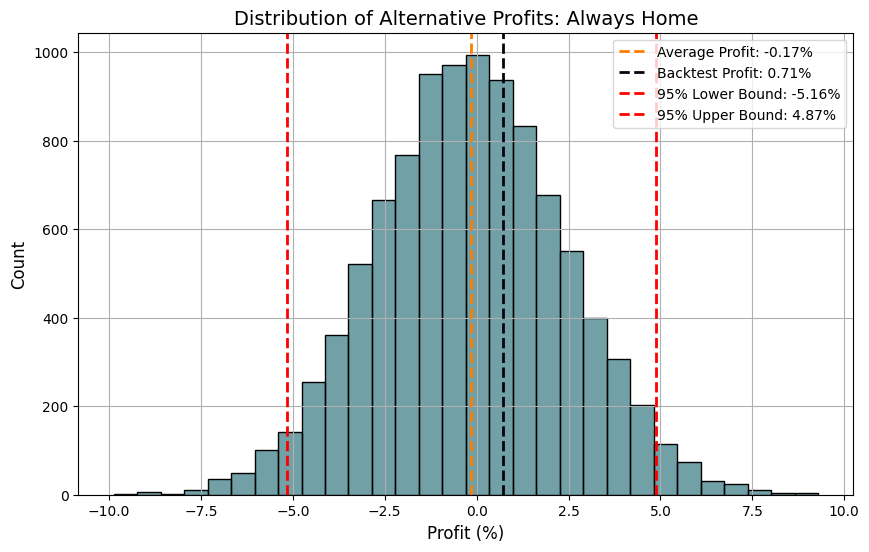


Summary of random effect analysis
  Average profit over simulations: -0.17%
  95% interval of profit: [-5.16%, 4.87%]
  Probability of ending better off than in the backtest: 36.10%
  Probability of ending with a loss: 52.97%


In [7]:
seasons = [i for i in range(2019, 2025)]
posterior_always_bet_home = always_bet_home(df, seasons)

Betting on the home team brings slightly different results than placing random bets. The first difference we observe is in sharpness: over all backtested seasons, the mean sharpness we achieved was 0.46, with a 95% credible interval of [0.44, 0.48]. Yet, even though we had more success at placing right bets, our financial performance was worse. In three out of the six backtested seasons, we gathered losses, and our final profit after six seasons was only 0.71%. But how is it possible that our financial performance was worse, if our sharpness was better? The answer lies on the fact that the odds distribution for betting on the home team is different from the odds distribution of betting randomly. Given that bookmakers know home teams have an advantage, the odds offered for home victories are, in general, lower than the odds offered by away victories. However, by betting randomly, we sometimes place bets on away victories with higher odds — and sometimes these bets turn out successful, giving us a higher payoff. The Monte Carlo simulations shine some more light on how betting on the home team might perform. Over ten thousand trials, we had a mean loss of 0.17%, with 95% of the outcomes falling between [-5.16%, 4.87%]. This means that our backtested peformance was slightly better than what we should expect, but in total, a bettor would have a 52.97% chance of ending up with a loss by always betting on the home team.